In [2]:
#Import parent directory
import sys
import os
sys.path.insert(0, '..')

import mujoco
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

### Loading the model

In [3]:
model = mujoco.MjModel.from_xml_path('robot.xml')
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

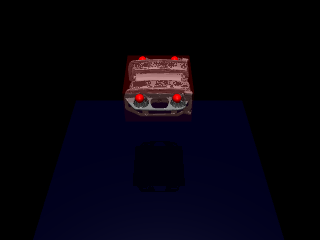

In [4]:
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

### Sliding mode control

#### Model

In [5]:
heavy_mapping = [[-0.7, -0.7, 0.7, 0.7, 0., 0., 0., 0.],
                 [0.7, -0.7, 0.7, -0.7, 0., 0., 0., 0.],
                 [0., 0., 0., 0., -1., 1., -1., 1.],
                 [0., 0., 0., 0., 0.218, 0.218, 0.218, 0.218],
                 [0., 0., 0., 0., 0.12, -0.12, -0.12, 0.12],
                 [0.004, -0.004, -0.004, 0.004, 0., 0., 0., 0.]]

heavy_inputs_inv = np.linalg.pinv(heavy_mapping)
heavy_inputs_inv.shape

(8, 6)

In [6]:
from quat_routines import quaternion_product, quat2so3, quat2euler, conjugate, quat2rot, skew

def R(X):
  q = X[3:]
  return quat2rot(q).T

def T(X):
  q = X[3:]
  p, e1, e2, e3 = q
  return 0.5*np.array([[-e1, -e2, -e3],
                         [p, -e3, e2],
                         [e3, p, -e1],
                         [-e2, e1, p]])


def J(X):
    return np.block([[R(X), np.zeros((3,3))], [np.zeros((4,3)), T(X)]])

In [7]:
m = model.body('body').mass[0]
length, width, height = model.geom('box').size

# inertia for a box
I_0 = np.diag(model.body('body').inertia)

M_rb = np.block([[m*np.eye(3), np.zeros((3, 3))], [np.zeros((3, 3)), I_0]])

M = M_rb
M_inv = np.linalg.inv(M)

In [8]:
def C_rb(vel):
    v, w = vel[:3], vel[3:]
    return np.block([[m*skew(w), np.zeros((3, 3))], [np.zeros((3, 3)), -skew(I_0@w)]])

def C(v):
    return C_rb(v)

In [9]:
K_1 = np.diag([10, 10, 10, 0, 0, 0])  # коэффициенты взяты из головы
K_2 = np.diag([0.1, 0.1, 0.1, 0, 0, 0])  # коэффициенты взяты из головы

def D(vel):
    speed = np.linalg.norm(vel)

    D_lin = K_1
    D_quad = K_2*speed

    return D_lin + D_quad

In [10]:
r_b = model.body('buoyancy').pos

W = -m*(model.opt.gravity[-1])
B = W*1.0


def f_g(X):
  return -R(X).T@np.array([0, 0, W])

def f_b(X):
  return R(X).T@np.array([0, 0, B])

def g_(X):
    res = np.zeros((6, ))

    fg = f_g(X)
    fb = f_b(X)

    res[:3] = fg + fb
    res[3:] = np.cross(r_b, fb)
    return res

#### Control

In [11]:
l = 1  
phi = [0.05, 0.05, 0.05, 0.3, 0.3, 0.3]  # error bounds
K = [6.56887255,  5.97797786,  7.92404967, 21.88823654, 15.03985469,
       17.54285714]  # control gains

def sliding_mode(X, x_d):

  x, v = X[:7], X[7:]

  e_b = J(x).T@(np.array(x) - np.array(x_d))
  s = v + l*e_b
  a_r = - l*e_b  # ds/dt=0

  u_hat = M_rb@a_r + C(v)@v + D(v)@v + g_(X) - l*e_b

  s_sign = np.sign(s)

  for i in range(len(s_sign)):
    if abs(s[i]) < phi[i]:
      s_sign[i] = s[i]/phi[i]

  u_s = -np.diag(K)*M_rb@s_sign

  return u_hat + u_s

In [12]:
X_0 = [1, -1, -1.5, 0.9238795, 0, 0, 0.3826834,  1, 0, 0, 0, 0, 0]

X_d = [0.5, -0.7, -0.5, 1, 0, 0, 0]

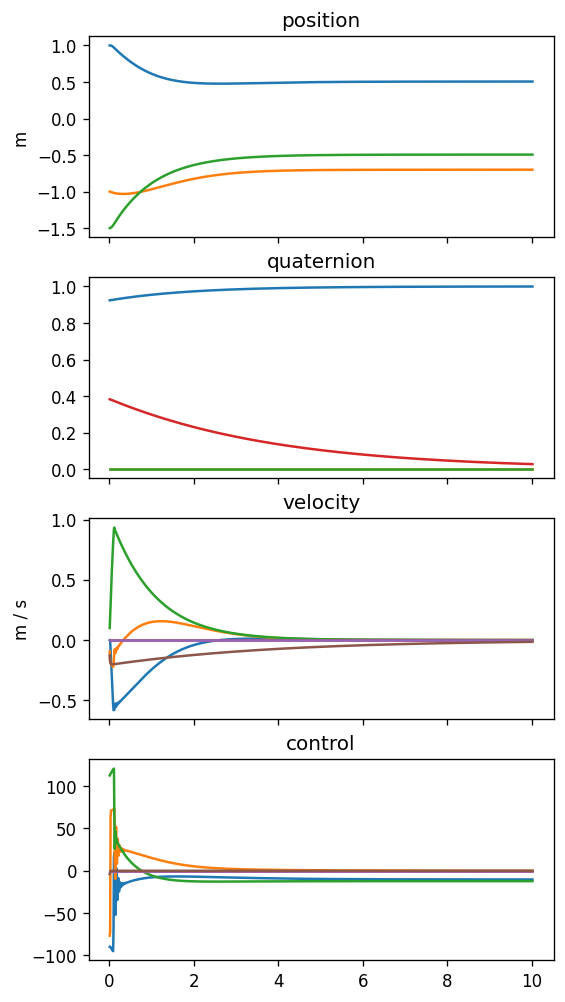

In [14]:
# Parameters.
DURATION = 10         # seconds
FRAMERATE = 60        # Hz

timevals = []
position = []
quat = []
velocity = []
control = []
error = []

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)

# buonancy
data.xfrc_applied[model.body('buoyancy').id][2] = W*1.1
model.opt.wind = [0.5, 0, 0]

frames = []
step = 0

# # Allocate position difference dq.
# dq = np.zeros(model.nv)

data.qpos = X_0[:7]
x_d = X_d


while data.time < DURATION:
  # Get state difference dx.
  # mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  # dx = np.hstack((dq, data.qvel)).T

  X = np.append(data.qpos, data.qvel, 0)

  # Control law.
  u = sliding_mode(X, x_d)

  data.ctrl = heavy_inputs_inv @ u

  # Step the simulation.
  mujoco.mj_step(model, data)

  timevals.append(data.time)
  control.append(u)
  position.append(data.qpos[0:3].copy())
  quat.append(data.qpos[3:7].copy())
  velocity.append(data.qvel[0:6].copy())
  error.append(data.qpos[0:3].copy() - x_d[:3])

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

dpi = 120
width = 600
height = 1200
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(4, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, position)
ax[0].set_title('position')
ax[0].set_ylabel('m')

ax[1].plot(timevals, quat)
ax[1].set_title('quaternion')
ax[1].set_ylabel('')

ax[2].plot(timevals, velocity)
ax[2].set_title('velocity')
ax[2].set_ylabel('m / s')

ax[3].plot(timevals, control)
ax[3].set_title('control')
ax[3].set_ylabel('')

plt.show()

media.show_video(frames, fps=FRAMERATE)